<h1>Objectif : Prévoir la production de l’énergie solaire </h1>

**Importation des bibliothèques**

In [129]:
from IPython.utils import io
with io.capture_output() as captured:
  import folium
  import json
  import numpy as np
  import pandas as pd
  import matplotlib.pyplot as plt
  import seaborn as sns
  from scipy.stats import pearsonr
  from statsmodels.tsa.seasonal import seasonal_decompose
  from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
  import statsmodels.api as sm
  import scipy.stats
  import datetime
  from sklearn.model_selection import KFold
  from sklearn import preprocessing
  from sklearn.cluster import KMeans
  from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
  from sklearn.neighbors import KNeighborsClassifier
  from sklearn.ensemble import RandomForestClassifier
  from sklearn.neural_network import MLPClassifier
  from sklearn.model_selection import cross_val_score
  from sklearn.linear_model import Lasso
  from sklearn.ensemble import RandomForestRegressor
  from sklearn.neural_network import MLPRegressor
  from sklearn.model_selection import cross_validate
  from sklearn.model_selection import train_test_split
  import statsmodels.api as sm
  %matplotlib inline

**Importation des données**

In [130]:
chemin_drive = '/content/drive/MyDrive/Colab Notebooks/'
with io.capture_output() as captured:
  df_production = pd.read_csv(chemin_drive+'eco2mix-regional-cons-def.csv', sep=';');
  df_rayonne = pd.read_csv(chemin_drive+'rayonnement-solaire-vitesse-vent-tri-horaires-regionaux.csv', sep=';');
  geo = json.load(open("/content/drive/MyDrive/Colab Notebooks/georef-france-region.geojson"));

**Prétraitements**

In [131]:
columns = ['Région','Date','Date - Heure', 'Solaire (MW)']
df_production = df_production.drop(df_production.columns.difference(columns),axis=1)
df_production = df_production.dropna()
df_ztemp = df_production.groupby(['Région'])['Solaire (MW)'].sum().reset_index().sort_values(by=['Solaire (MW)'], ascending=False)
regions = df_ztemp['Région'].unique().tolist()

In [132]:
df_rayonne = df_rayonne.drop(['Code INSEE région', 'Vitesse du vent à 100m (m/s)'],axis=1)
df_rayonne.rename(columns={'Date': 'Date - Heure'}, inplace=True)
df_rayonne.rename(columns={'Rayonnement solaire global (W/m2)': 'Rayonnement (W/m2)'}, inplace=True)

In [133]:
df = pd.merge(df_production, df_rayonne)
df['Heure']=df['Date - Heure'].apply(lambda x : str(x)[11:13])
df['Date'] = pd.to_datetime(df['Date'])
df['Jour']=df['Date'].apply(lambda x : x.weekday())

<h1>Analyses préliminaires et interprétations </h1>

**Evolution moyenne annuelle de la production globale**

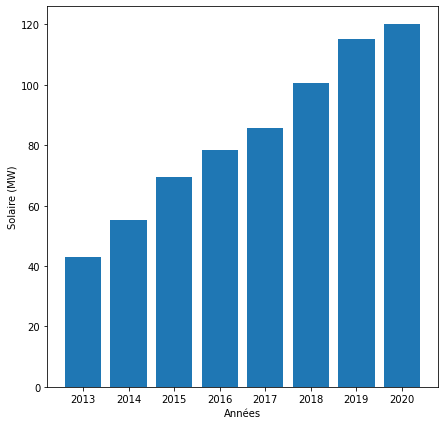

In [134]:
#L'évolution moyenne annuelle de la production nationale de l'énergie solaire de 2013 à 2020.
df_production['Année']=df_production['Date'].apply(lambda x : str(x)[:4])
df_temp= df_production.groupby(['Année']).aggregate({'Solaire (MW)': 'mean'}).reset_index()
fig = plt.figure(figsize=(7,7))
plt.bar(df_temp['Année'][:-1], df_temp['Solaire (MW)'][:-1]) ; 
plt.xlabel('Années')
plt.ylabel('Solaire (MW)')
plt.show() 

**Evolution moyenne annuelle de la production par régions**

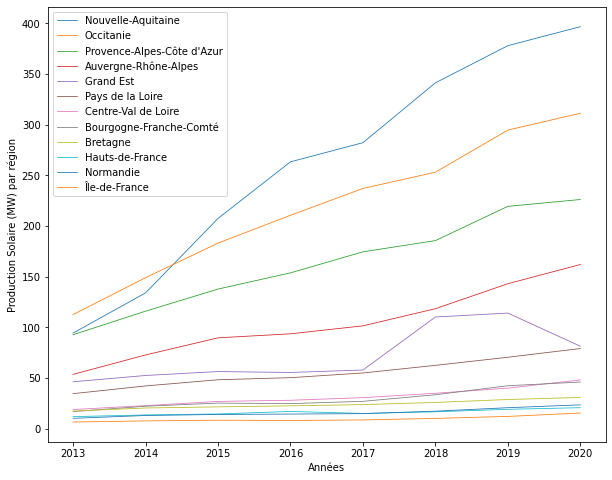

In [135]:
#L'évolution moyenne annuelle par régions de la production nationale de l'énergie solaire de 2013 à 2020.
df_temp= df_production.groupby(['Région','Année']).aggregate({'Solaire (MW)': 'mean' }).reset_index()
df_temp.head(30)
x = df_temp['Année'].unique().tolist()
x = [i+' h' for i in x]
fig = plt.figure(figsize=(10,8))
for r in range(len(regions)) : 
  plt.plot(df_temp['Année'].unique().tolist()[:-1], df_temp[df_temp['Région']==regions[r]]['Solaire (MW)'][0:-1],
           linewidth=0.8, label=regions[r])
plt.xlabel('Années')
plt.ylabel('Production Solaire (MW) par région')
plt.legend();

**Répartition de la production moyenne de l'énergie solaire par région.**

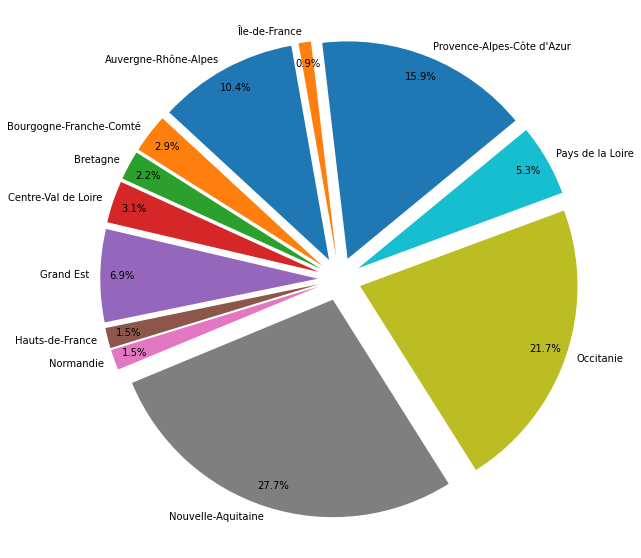

In [136]:
#La répartition de la production moyenne de l'énergie solaire par région. 
plt.figure( figsize= (10, 10) )
explode = [0.1 for i in range(12)] 
df_temp = df.groupby(["Région"]).agg({'Solaire (MW)': 'mean'}).reset_index()
x= df_temp['Solaire (MW)']
labels = df_temp['Région'].unique().tolist()
plt.pie(x, labels =labels, rotatelabels=False, explode=explode, autopct='%1.1f%%', 
        pctdistance=0.9, labeldistance=1.05, startangle=100, shadow=False );

**Répartition spatiale de la production**

In [137]:
df_temp = df.groupby(['Région']).aggregate({'Solaire (MW)': 'mean'}).reset_index()
del geo["features"][6]
for reg in geo["features"]:
  prop = reg["properties"]
f = folium.Figure(width=800, height=600)
France_reg_circle = folium.Map(location= [47, 2], zoom_start=6, min_zoom = 6,  max_zoom = 6, max_bounds=True ).add_to(f)
#France_reg_circle = folium.Map(location=[48.856578, 2.351828],max_bounds=True)
#France_reg_circle = folium.Map(location = [48.856578, 2.351828], zoom_start = 5)
for arr in geo["features"]:
    prop = arr["properties"]
    folium.CircleMarker(prop["geo_point_2d"], 
                        popup = prop["reg_name"],
                        color="Blue",
                        fill_color="Blue",
                        fill_opacity = 0.8,
                        radius = int(df_temp[df_temp['Région']==prop["reg_name"]]['Solaire (MW)']) / 10).add_to(France_reg_circle)
France_reg_circle

**Evolution de la production par région et en fonction des heures de la journée.**

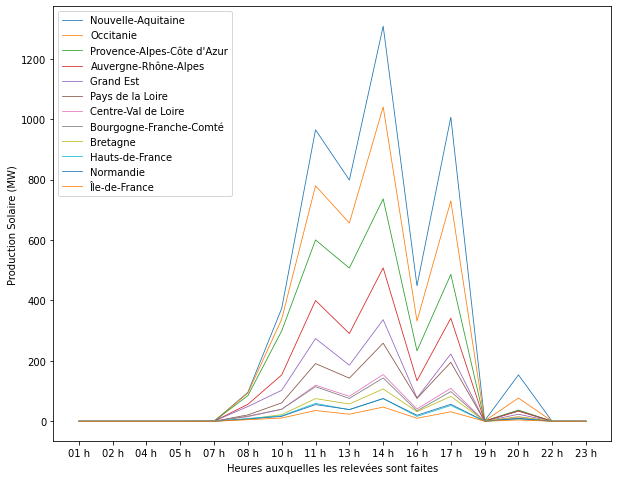

In [138]:
#L'évolution de la production moyenne de l'énergie solaire par région et en fonction des heures de la journée. 
df_temp= df.groupby(['Région','Heure']).aggregate({'Solaire (MW)': 'mean', 'Rayonnement (W/m2)': 'mean' }).reset_index()
fig = plt.figure(figsize=(10,8))
for r in range(len(regions)) : 
  x = df_temp[df_temp['Région']==regions[r]]['Heure'].unique().tolist()
  x = [i+' h' for i in x]
  plt.plot(x, df_temp[df_temp['Région']==regions[r]]['Solaire (MW)'], linewidth=0.8, label=regions[r])
plt.xlabel('Heures auxquelles les relevées sont faites')
plt.ylabel('Production Solaire (MW)')
plt.legend();

**Evolution en fonction des jours de la semaine.** 

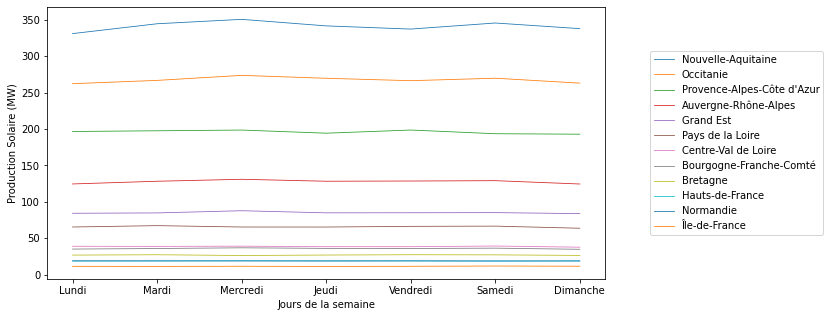

In [139]:
#L'évolution de la production moyenne de l'énergie solaire en fonction des jours de la semaine. 
df_temp= df.groupby(['Région','Jour']).aggregate({'Solaire (MW)': 'mean', 'Rayonnement (W/m2)': 'mean' }).reset_index()
fig = plt.figure(figsize=(10,5))
for r in range(len(regions)) : 
  x = df_temp[df_temp['Région']==regions[r]]['Jour'].unique().tolist()
  plt.plot(x, df_temp[df_temp['Région']==regions[r]]['Solaire (MW)'], linewidth=0.8, label=regions[r])
plt.xlabel('Jours de la semaine')
plt.xticks([0, 1, 2,3,4,5,6], ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi','Samedi','Dimanche'])
plt.ylabel('Production Solaire (MW)')
plt.legend(loc='center right', bbox_to_anchor=(1.4, 0.5));

**Etude de la corrélation entre les productions moyennes annuelles des régions.**

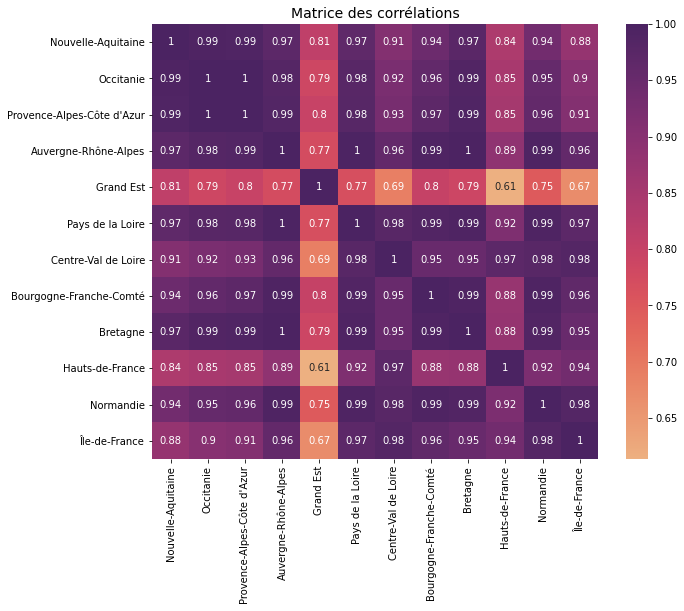

In [140]:
#Etude de la corrélation entre les productions moyennes annuelles. 
import pandas as pd
df_corr =pd.DataFrame({})
for c in range(len(regions)):
  df_corr[regions[c]]= pd.Series((df_production[df_production['Région']
                           ==regions[c]]).groupby(['Année'],
                                                  as_index=False).agg({'Solaire (MW)': 'mean'})['Solaire (MW)'])
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
sns.heatmap(df_corr.corr(), annot=True, cmap='flare', ax=ax)
ax.set_title('Matrice des corrélations', fontsize=14)
plt.show();

**Nuage de points rayonnement (W/m2)/production énergie Solaire (MW).**

1) On peut se focaliser sur les observation >0 (journée). 

2) La région ne compte pas vraiment. 

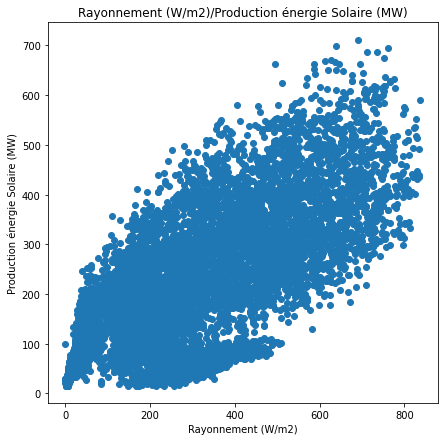

In [142]:
#Le nuage de points rayonnement (W/m2)/production énergie Solaire (MW). 
df_temp = df.copy()
df_temp=df_temp[df_temp['Solaire (MW)']>15]  
df_temp = df_temp.drop(['Région'],axis=1)
df_temp= df_temp.groupby(['Date - Heure']).aggregate({'Solaire (MW)': 'mean', 'Rayonnement (W/m2)': 'mean' }).reset_index()
plt.figure( figsize= (7, 7) )
plt.scatter(df_temp['Rayonnement (W/m2)'], df_temp['Solaire (MW)'])
plt.title('Rayonnement (W/m2)/Production énergie Solaire (MW)')
plt.xlabel('Rayonnement (W/m2)')
plt.ylabel('Production énergie Solaire (MW)')
plt.show()

<h1>Quelques commentaires <h1/>

Nous pouvons formuler les observations suivantes : 

*   La production globale d'énergie solaire en France, croit d'une année à l'autre. La production moyenne a été multipliée par 3 entre 2013 et 2020. Cette croissance est plus importante pour certaines régions telles que Nouvelle-Aquitaine, l'Occitanie, Provence-Alpes-Côte d'Azur et Auvergne-Rhône-Alpes. Le niveau de production est très faible et reste stagnant depuis 2013 pour les régions telles que : Île-de-France, Normandie, Hauts-de-France, Bretagne, Bourgogne-Franche-Comté, Centre-Val de Loire et Pays de la Loire. Après une période de croissance, on note depuis 2019 une décroissance de la production de la région de Grand Est. 

*   La production de l'énergie solaire est concentrée sur le créneau horaire 7h-19h : c'est la période de la journée où on dispose du rayonnement solaire nécessaire à la production. 

*   Les variations relatives observées dans la production ne dépendent ni de la région ni du jour de la semaine. En d'autres termes, il y'a une corrélation  entre les productions. Cela se vérifie à travers la table de corrélation  proposée. 

*   Le nuage des points montre qu'il peut avoir corrélation  linéaire  entre la production et le niveau de rayonnement. 

<h1>Variation de la production d'énergie solaire </h1>

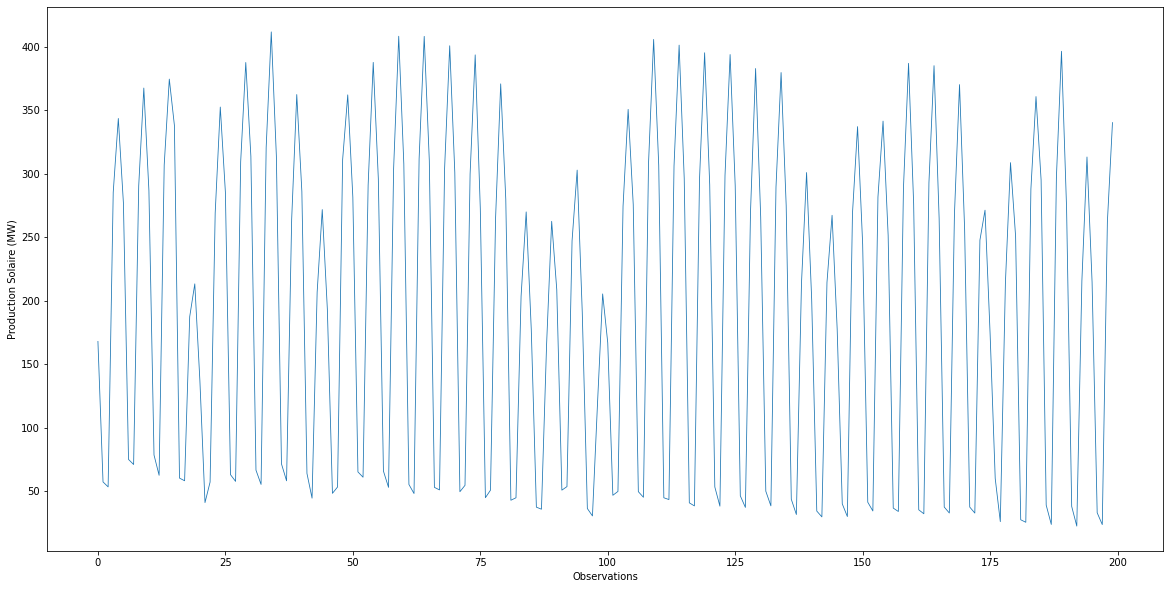

In [143]:
#L'évolution de la production dans le temps. 
fig = plt.figure(figsize=(20,10))
#x = range(df_temp['Solaire (MW)'].shape[0])
deb = 890
nb = 200
x = range(nb)
plt.plot(x, df_temp['Solaire (MW)'][deb:deb+nb], linewidth=0.8, label=regions[r])
#plt.plot(x, df_temp['Rayonnement (W/m2)'][deb:deb+nb], linewidth=0.8, color='r', label=regions[r])
plt.xlabel('Observations')
plt.ylabel('Production Solaire (MW)');

<h1> Modélisation avec Scikit-Learn </h1>

Dans cette section, nous proposons quelques modèles basés sur Scikit-Learn. Nous allons dans un premier temps, préparer les jeux de données d'entrainement et de test. Nous allons séparer la cible (Y : production solaire) des données explicatives (Data : rayonnement soalaire et Production soalaire sur les 7 jours précédents).
Nous allons également créer une variable cible de catégories Y_cut en créant trois tranches de production d'énergie solaire.
Ces tranches sont construites d'après les quantiles 33% et 66%.

In [144]:
"""
Construction du dataframe constitué de la production des 7 derniers jours avant et du rayonement du jour (météo). 
"""
n =8 #nb d'observation considérées 
m = 0 #nb d'observations d'écart
colonnes = []
p=m+n
for i in range (n):
  colonnes.append('prod_'+str(p-i)+'_av')
for i in range (n):
  colonnes.append('Rayo_'+str(n-i)+'_av')
colonnes.append('Rayo_0_av')
colonnes.append('Solaire (MW)')

data = pd.DataFrame(columns=colonnes)
for i in range (p,df_temp.shape[0]) : 
  data.loc[(i-n)]= [k for k in pd.Series (df_temp.iloc[(i-p):(i-m) , 1:2]['Solaire (MW)'])] + [l for l in pd.Series (df_temp.iloc[(i-n):(i+1) , 2:3]['Rayonnement (W/m2)'])]+[df_temp['Solaire (MW)'][i]]


In [145]:
data.head()

,prod_8_av,prod_7_av,prod_6_av,prod_5_av,prod_4_av,prod_3_av,prod_2_av,prod_1_av,Rayo_8_av,Rayo_7_av,Rayo_6_av,Rayo_5_av,Rayo_4_av,Rayo_3_av,Rayo_2_av,Rayo_1_av,Rayo_0_av,Solaire (MW)
0,74.333333,154.700000,93.000000,36.200000,110.200000,62.142857,65.166667,126.333333,24.576667,163.441000,171.808000,12.056000,117.281000,125.194286,24.820000,167.690000,131.015000,40.250000
1,154.700000,93.000000,36.200000,110.200000,62.142857,65.166667,126.333333,40.250000,163.441000,171.808000,12.056000,117.281000,125.194286,24.820000,167.690000,131.015000,19.582857,46.857143
2,93.000000,36.200000,110.200000,62.142857,65.166667,126.333333,40.250000,46.857143,171.808000,12.056000,117.281000,125.194286,24.820000,167.690000,131.015000,19.582857,168.474167,95.416667
3,36.200000,110.200000,62.142857,65.166667,126.333333,40.250000,46.857143,95.416667,12.056000,117.281000,125.194286,24.820000,167.690000,131.015000,19.582857,168.474167,157.762500,31.750000
4,110.200000,62.142857,65.166667,126.333333,40.250000,46.857143,95.416667,31.750000,117.281000,125.194286,24.820000,167.690000,131.015000,19.582857,168.474167,157.762500,24.970000,79.666667


In [146]:
Y = data['Solaire (MW)']
data =  data.loc[:,data.columns.difference(['Solaire (MW)'])]
Y_cut = pd.cut(Y,Y.quantile([0,.33,.66,1]), include_lowest=True) 
print("Quantiles à 33% et 66% :")
print(Y.quantile([.33,.66]))

Quantiles à 33% et 66% :
0.33    117.205111
0.66    277.833333
Name: Solaire (MW), dtype: float64


In [147]:
compt =0
for i in range (1,Y_cut.shape[0]):
  if Y_cut[i] != Y_cut[i-1]:
    compt +=1
print('Proportion : ',compt*100/Y_cut.shape[0])

Proportion :  53.0253984063745


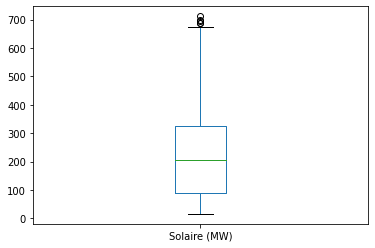

In [148]:
# On visualise la boxplot de la production solaire pour chercher d'éventuelles valeurs extrêmes. 
Y.plot.box()

In [149]:
# On tire 70% parmis les observations, sans remplacement
ix_train = data.sample(frac=.7, replace=False, random_state=0).index.values 
ix_test = data.index.difference(ix_train).values # Les autres iandexes forment le test set
print("Taille du jeu d'entraîntement : \n{}".format(len(ix_train)))
print("\nTaille du jeu de test : \n{}".format(len(ix_test)))

Taille du jeu d'entraîntement : 
5622

Taille du jeu de test : 
2410


In [150]:
"""
Le train set et le test set seront sélectionnés par leurs indexes.
"""
print("Moyenne des productions solaires sur le jeu d'entraînement :")
print(round(Y.loc[ix_train].mean()))
print("\nMoyenne des productions solaires sur le jeu de test :")
print(round(Y.loc[ix_test].mean()))

Moyenne des productions solaires sur le jeu d'entraînement :
220

Moyenne des productions solaires sur le jeu de test :
224


In [151]:
# Création de 5 jeux d'indexes :
kf = KFold(n_splits=5)
folds = [(train, test) for train, test in kf.split(data.index.values)]
print("Nombre de tupple crées :")
print(len(folds))
print("\nNombre d'éléments dans le train et le test set du premier fold :")
print(len(folds[0][0]), len(folds[0][1]))

Nombre de tupple crées :
5

Nombre d'éléments dans le train et le test set du premier fold :
6425 1607


In [152]:
### Standardisation des données
# Initialisation du standard scaler :
std_scaler = preprocessing.StandardScaler()
std_scaler.fit(data)
data.loc[:,:] = std_scaler.transform(data)


<h2>Clustering non supervisé </h2>

Nous allons utilisé l'algorithme des k-means pour regrouper les productions en 3 classes. Nous allons comparer les classes issues de l'algorithme au regroupement par tranche de productions que nous avons envisagé. 

On affiche les boxplot des productions par clusters :


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


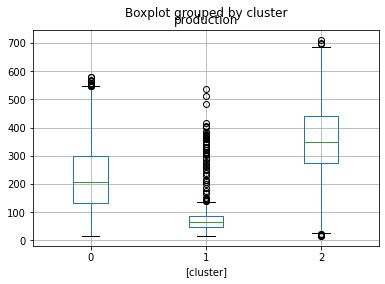

In [153]:
#Clustering non supervisé 

# Initialisation des paramètres de l'algorithme :
Kmeans_model = KMeans(n_clusters=3, init = 'k-means++', random_state=123)

# On applique le clustering sur le jeu d'entraînement (train) :
# On enregistre dans la variable clusters le numéro du cluster auquel chaque enregistrement est identifié
clusters = Kmeans_model.fit_predict(data.loc[ix_train])

# On enregistre les clusters et les colonnes à comparer dans un dataframe pandas :
train_clusters = pd.DataFrame([*zip(clusters,Y.loc[ix_train],Y_cut.loc[ix_train])], 
                              columns=['cluster','production','production_cut'])

train_clusters.boxplot(by='cluster')
print('On affiche les boxplot des productions par clusters :')

In [154]:
print("On affiche la table des profils ligne par tranche de production d'énergie, pour chaque cluster :")
cross_table = pd.crosstab(train_clusters.cluster, train_clusters.production_cut, normalize='index')
cross_table.style.background_gradient(cmap='Reds', axis=1, low=0, high=1)

On affiche la table des profils ligne par tranche de production d'énergie, pour chaque cluster :


production_cut,"(15.999, 117.205]","(117.205, 277.833]","(277.833, 711.833]"
cluster,,,
0,0.195562,0.509709,0.294730
1,0.943796,0.029927,0.026277
2,0.024123,0.239766,0.736111


In [155]:
# Pour ligne du jeu test, on retrouve le cluster auquel elle appartient. 
clusters_test = Kmeans_model.predict(data.loc[ix_test])
# On construit un dictionnaire pour associer à chaque cluster la classe dominante :
dict_cluster_pred = {
    0:'(117.205, 277.833]',
    1:'(15.999, 117.205]',
    2:'(277.833, 711.833]' 
}
y_test_clusters = [dict_cluster_pred[c] for c in clusters_test]
# Calcul de l'accuracy et du recall :
print("Classe dominante du cluster :\n- Accuracy : {}\n- Recall : {}\n- Score F1  : {}".format(
    round(accuracy_score(y_test_clusters, Y_cut.astype(str)[ix_test]),4),
    round(recall_score(y_test_clusters,Y_cut.astype(str)[ix_test], average='macro'),4),
    round(f1_score(y_test_clusters,Y_cut.astype(str)[ix_test], average='macro'),4)
))

Classe dominante du cluster :
- Accuracy : 0.6631
- Recall : 0.7272
- Score F1  : 0.6731


<h2>Quelques commentaires </h2>
On constate que les trois clusters proposés par l'algorithme correspondent plus ou moins à nos classes de productions : le cluster 0 correspond à la classe intermédiaire, le cluster 1 correspond à la classe inférieure et le cluster 2 correspond à la classe supériure. Si nous classons chaque cluster selon la classe dominante, nous abstenons un score d'environ 60%, ce qui est tout à fait satisfaisant. 


<h1>Classification supervisée</h1>
Dans cette section, nous allons effectuer trois types de Classification supervisée : K plus Proches Voisins - Forêt Aléatoire pour la Classification - Multi Layer Perceptron Classifier. La variable cible c'est la classe de production de l'énergie solaire et les variables explicatives sont les productions observées avant et les prévisions du rayonnement solaire. 

In [156]:
#Classification supervisée, pour retrouver une tranche de production d'énergie solaire :
# Initialisation des modèles :
KNN_model = KNeighborsClassifier(n_neighbors=11)
RFC_model = RandomForestClassifier(n_estimators=100, max_depth=8, min_samples_leaf=7, random_state=0)
MLPC_model = MLPClassifier(hidden_layer_sizes=(50,), activation='relu', max_iter=1000, random_state=0)

In [157]:
# Pour la prédiction, le type Categorical (catégories ordonnées de pandas)
# n'est pas compatible avec les fonctions de sklearn.metrics, on 
# le convertit dans le type string :
Y_cut_str = Y_cut.astype(str)
# Entraînement :
%time KNN_model.fit(data.loc[ix_train], Y_cut_str.loc[ix_train])
%time RFC_model.fit(data.loc[ix_train], Y_cut_str.loc[ix_train])
%time MLPC_model.fit(data.loc[ix_train], Y_cut_str.loc[ix_train])

# Prédiction sur le jeu de test :
y_test_knn = KNN_model.predict(data.loc[ix_test])
y_test_rfc = RFC_model.predict(data.loc[ix_test])
y_test_mlpc = MLPC_model.predict(data.loc[ix_test])

# On affiche la précision (accuracy) et le rappel (recall) pour chaque méthode :
from sklearn.metrics import accuracy_score, recall_score
print("\nPlus proches voisins :\n- Accuracy : {}\n- Recall : {}\n- Score F1  : {}".format(
    round(accuracy_score(y_test_knn, Y_cut.astype(str)[ix_test]),4),
    round(recall_score(y_test_knn,Y_cut.astype(str)[ix_test], average='macro'),4),
    round(f1_score(y_test_knn,Y_cut.astype(str)[ix_test], average='macro'),4)
))
print("\nRandom Forest Classifier :\n- Accuracy : {}\n- Recall : {} \n- Score F1  : {}".format(
    round(accuracy_score(y_test_rfc, Y_cut.astype(str)[ix_test]),4),
    round(recall_score(y_test_rfc,Y_cut.astype(str)[ix_test], average='macro'),4),
    round(f1_score(y_test_rfc,Y_cut.astype(str)[ix_test], average='macro'),4)
))
print("\nMulti Layer Perceptron Classifier :\n- Accuracy : {}\n- Recall : {}\n- Score F1  : {}".format(
    round(accuracy_score(y_test_mlpc, Y_cut.astype(str)[ix_test]),4),
    round(recall_score(y_test_mlpc,Y_cut.astype(str)[ix_test], average='macro'),4),
    round(f1_score(y_test_mlpc,Y_cut.astype(str)[ix_test], average='macro'),4)
))

CPU times: user 19.9 ms, sys: 0 ns, total: 19.9 ms
Wall time: 19.9 ms
CPU times: user 1.47 s, sys: 1.15 ms, total: 1.47 s
Wall time: 1.48 s
CPU times: user 6.99 s, sys: 20 ms, total: 7.01 s
Wall time: 7.03 s

Plus proches voisins :
- Accuracy : 0.8315
- Recall : 0.8351
- Score F1  : 0.8333

Random Forest Classifier :
- Accuracy : 0.8519
- Recall : 0.8602 
- Score F1  : 0.8543

Multi Layer Perceptron Classifier :
- Accuracy : 0.8768
- Recall : 0.8771
- Score F1  : 0.8772


In [159]:
"""
Afin de s'assurer que les performances de nos modèles ne sont pas "dues à la chance", 
nous allons effectué une cross-validation.
"""
# Cross validation avec 5 folds : 
scores_knn = cross_val_score(KNN_model, data, Y_cut_str, cv=5)
scores_rfc = cross_val_score(RFC_model, data, Y_cut_str, cv=5)
scores_mlpc = cross_val_score(MLPC_model, data, Y_cut_str, cv=5)

# Afficher la moyenne et l'écart type des accuracy :
print("Accuracy KNN  : %0.2f (+/- %0.2f)" % (scores_knn.mean(), scores_knn.std() * 2))
print("Accuracy RFC  : %0.2f (+/- %0.2f)" % (scores_rfc.mean(), scores_rfc.std() * 2))
print("Accuracy MLPC : %0.2f (+/- %0.2f)" % (scores_mlpc.mean(), scores_mlpc.std() * 2))

Accuracy KNN  : 0.82 (+/- 0.04)
Accuracy RFC  : 0.84 (+/- 0.04)
Accuracy MLPC : 0.86 (+/- 0.03)


In [160]:
"""
Nous aurions pu procéder à la cross validation avec nos index construits dans la partie sur les index. 
"""
# Création de 5 jeux d'indexes :
kf = KFold(n_splits=5)
folds = [(train, test) for train, test in kf.split(data.index)]
# KFold renvoie les index numérotés et pas le nom de la ligne
# on les utilisera avec .iloc et pas .loc comme précédemment.

# Application dans une boucle :
accuracy_knn, accuracy_rfc, accuracy_mlpc = [], [], []
for ix_train_cv, ix_test_cv in folds :
    # Entraînement :
    KNN_model.fit(data.iloc[ix_train_cv], Y_cut_str.iloc[ix_train_cv])
    RFC_model.fit(data.iloc[ix_train_cv], Y_cut_str.iloc[ix_train_cv])
    MLPC_model.fit(data.iloc[ix_train_cv], Y_cut_str.iloc[ix_train_cv])

    # Prédiction sur le jeu de test :
    y_test_knn = KNN_model.predict(data.iloc[ix_test_cv])
    y_test_rfc = RFC_model.predict(data.iloc[ix_test_cv])
    y_test_mlpc = MLPC_model.predict(data.iloc[ix_test_cv])

    # Calcul de l'accuracy :
    accuracy_knn.append(accuracy_score(y_test_knn, Y_cut_str.iloc[ix_test_cv]))
    accuracy_rfc.append(accuracy_score(y_test_rfc, Y_cut_str.iloc[ix_test_cv]))
    accuracy_mlpc.append(accuracy_score(y_test_mlpc, Y_cut_str.iloc[ix_test_cv]))
    
# Afficher la moyenne et l'écart type des accuracy :
print("Accuracy KNN  : %0.2f (+/- %0.2f)" % (np.mean(accuracy_knn), np.std(accuracy_knn) * 2))
print("Accuracy RFC  : %0.2f (+/- %0.2f)" % (np.mean(accuracy_rfc), np.std(accuracy_rfc) * 2))
print("Accuracy MLPC : %0.2f (+/- %0.2f)" % (np.mean(accuracy_mlpc), np.std(accuracy_mlpc) * 2))

Accuracy KNN  : 0.84 (+/- 0.05)
Accuracy RFC  : 0.85 (+/- 0.04)
Accuracy MLPC : 0.88 (+/- 0.03)


In [161]:
#Pour le model de Random Forest, on affiche la matrice de confusion
# Entrainement et prédiction 
RFC_model.fit(data.loc[ix_train], Y_cut_str.loc[ix_train])
y_test_rfc = RFC_model.predict(data.loc[ix_test])
y_test_rfc = pd.Series(y_test_rfc, name='Predictions') # Transformation en série pour donner un nom à la colonne

print("On affiche la matrice de confusion sur le jeu de test :")
cross_table = pd.crosstab(y_test_rfc, Y_cut_str.loc[ix_test].reindex(ix_test).reset_index(drop=True))
cross_table = cross_table.iloc[[1,0,2],[1,0,2]] # On réordonne les colonnes pour qu'elles soient dans le 'bon' ordre
cross_table.style.background_gradient(cmap='Reds', axis=1, low=0, high=1)

On affiche la matrice de confusion sur le jeu de test :


Solaire (MW),"(15.999, 117.205]","(117.205, 277.833]","(277.833, 711.833]"
Predictions,,,
"(15.999, 117.205]",650,39,7
"(117.205, 277.833]",109,690,117
"(277.833, 711.833]",2,83,713


<h1> Modélisation par régression</h1>

In [162]:
# Initialisation des modèles :
LASSO_model = Lasso(alpha=.1, random_state=0)
RFR_model = RandomForestRegressor(n_estimators=500, max_depth=20, min_samples_leaf=7, random_state=0)
MLPR_model = MLPRegressor(hidden_layer_sizes=(500,), activation='relu', max_iter=2000, random_state=0)

In [163]:
# Entraînement :
%time LASSO_model.fit(data.loc[ix_train], Y.loc[ix_train])
%time RFR_model.fit(data.loc[ix_train], Y.loc[ix_train])
%time MLPR_model.fit(data.loc[ix_train], Y.loc[ix_train])

# Prédiction sur le jeu de test :
y_test_lasso = LASSO_model.predict(data.loc[ix_test])
y_test_rfr = RFR_model.predict(data.loc[ix_test])
y_test_mlpr = MLPR_model.predict(data.loc[ix_test])

# On affiche la précision (accuracy) et le rappel (recall) pour chaque méthode :
from sklearn.metrics import r2_score, mean_squared_error
print("\nLASSO :\n- R2   : {}\n- RMSE : {}".format(
    round(r2_score(y_test_lasso, Y[ix_test]),4),
    round(np.sqrt(mean_squared_error(y_test_lasso, Y[ix_test])),4)
))
print("\nRandom Forest Regression :\n- R2   : {}\n- RMSE : {}".format(
    round(r2_score(y_test_rfr, Y[ix_test]),4),
    round(np.sqrt(mean_squared_error(y_test_rfr, Y[ix_test])),4)
))
print("\nMulti Layer Perceptron Regression :\n- R2   : {}\n- RMSE : {}".format(
    round(r2_score(y_test_mlpr, Y[ix_test]),4),
    round(np.sqrt(mean_squared_error(y_test_mlpr, Y[ix_test])),4)
))

CPU times: user 26.9 ms, sys: 15 ms, total: 41.9 ms
Wall time: 23.1 ms
CPU times: user 28.7 s, sys: 123 ms, total: 28.9 s
Wall time: 28.7 s
CPU times: user 1min 35s, sys: 59 s, total: 2min 34s
Wall time: 1min 19s

LASSO :
- R2   : 0.8203
- RMSE : 55.8127

Random Forest Regression :
- R2   : 0.9014
- RMSE : 41.9146

Multi Layer Perceptron Regression :
- R2   : 0.9315
- RMSE : 36.2606


In [164]:
# Cross validation avec 5 folds : 
%time scores_lasso = cross_validate(LASSO_model, data, Y, cv=5, scoring=["r2","neg_mean_squared_error"])
%time scores_rfr = cross_validate(RFR_model, data, Y, cv=5, scoring=["r2","neg_mean_squared_error"])
%time scores_mlpr = cross_validate(MLPR_model, data, Y, cv=5, scoring=["r2","neg_mean_squared_error"])

# Afficher la moyenne et l'écart type des accuracy :
print("\nR2 LASSO   : %0.2f (+/- %0.2f)" % (scores_lasso["test_r2"].mean(), scores_lasso["test_r2"].std() * 2))
print("RMSE LASSO : %0.2f (+/- %0.2f)" % (np.sqrt(scores_lasso["test_neg_mean_squared_error"]*-1).mean(), np.sqrt(scores_lasso["test_neg_mean_squared_error"]*-1).std() * 2))

print("\nR2 RFR     : %0.2f (+/- %0.2f)" % (scores_rfr["test_r2"].mean(), scores_rfr["test_r2"].std() * 2))
print("RMSE RFR   : %0.2f (+/- %0.2f)" % (np.sqrt(scores_rfr["test_neg_mean_squared_error"]*-1).mean(), np.sqrt(scores_rfr["test_neg_mean_squared_error"]*-1).std() * 2))

print("\nR2 MLPR    : %0.2f (+/- %0.2f)" % (scores_mlpr["test_r2"].mean(), scores_mlpr["test_r2"].std() * 2))
print("RMSE MLPR  : %0.2f (+/- %0.2f)" % (np.sqrt(scores_mlpr["test_neg_mean_squared_error"]*-1).mean(), np.sqrt(scores_mlpr["test_neg_mean_squared_error"]*-1).std() * 2))

CPU times: user 195 ms, sys: 231 ms, total: 426 ms
Wall time: 222 ms
CPU times: user 2min 49s, sys: 265 ms, total: 2min 50s
Wall time: 2min 49s
CPU times: user 7min 48s, sys: 4min 50s, total: 12min 39s
Wall time: 6min 27s

R2 LASSO   : 0.82 (+/- 0.07)
RMSE LASSO : 57.16 (+/- 14.46)

R2 RFR     : 0.90 (+/- 0.05)
RMSE RFR   : 42.54 (+/- 7.93)

R2 MLPR    : 0.93 (+/- 0.03)
RMSE MLPR  : 35.73 (+/- 7.63)


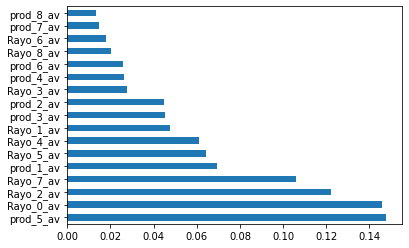

In [165]:
feat_importances = pd.Series(RFC_model.feature_importances_, index=data.columns)
feat_importances.nlargest(20).plot(kind = 'barh');